In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import csd
import seaborn as sns
import warnings

warnings.filterwarnings("ignore", category=UserWarning, module="scipy.signal")


from data_preprocessing import preprocess
from CSD_matrix import average_csd


In [2]:
#Data Frame from Original Data
df1 = preprocess()

In [3]:
"""Remove # To visualize Dataframe""" 
# df1

'Remove # To visualize Dataframe'

### $Statisticsl Analysis$

### (1) Generating a Null Dataset (Baseline):

"def generate_surrogate_csd"

This dataset consists of two CSD Matrices from both groups (schyzophrenic + healthy) and their difference Matrix.
We replicated the same CSD Matrix for the healthy group, and for the schyzophrenic group replicated that one again by adding random noise with a standard deviation of 0.2.
What we would have do differently is add noise to the healthy replica or replicate a new distribution via AR or Bootstrapping. It slipped off our minds but this might be a downfall to our current method.

In [4]:
def generate_surrogate_csd(healthy_csd_df, schizo_patient_ids, noise_std=0.05):
    """Generates Surrogate CSD Matrices for Schizophrenic Patients by Perturbing the Average Healthy CSD Matrix.
    This function returns """
    
    healthy_csd = healthy_csd_df.values
    surrogate_csd_dict = {}

    for patient_id in schizo_patient_ids:
        noise = np.random.normal(0, noise_std, size=healthy_csd.shape)
        perturbed_csd = healthy_csd + noise
        perturbed_csd = (perturbed_csd + perturbed_csd.T) / 2
        np.fill_diagonal(perturbed_csd, 1)

        surrogate_csd_dict[patient_id] = pd.DataFrame(perturbed_csd, columns=healthy_csd_df.columns, index=healthy_csd_df.index)

    return surrogate_csd_dict

In [5]:
def plot_correlation_matrices_with_surrogate(healthy_patients, dataframe, schizo_patients, wave_option='power_beta', surrogate_csd_dict=None, ax=None):
    """Visualize Surrogate Corelletion & Difference Matrices Next to Observed Set.
    This Function Returns Observed or Surrogate Difference Matrix Depending on What the "surrogate_csd_dict" parameter is set to"""
    avg_corr_healthy = average_csd(healthy_patients, dataframe, wave_option=wave_option, surrogate=False)

    if surrogate_csd_dict:
        surrogate_matrices = [surrogate_csd_dict[pid].values for pid in schizo_patients]
        avg_corr_schizo = np.mean(surrogate_matrices, axis=0)
        avg_corr_schizo = pd.DataFrame(avg_corr_schizo, columns=avg_corr_healthy.columns, index=avg_corr_healthy.index)
    else:
        avg_corr_schizo = average_csd(schizo_patients, dataframe, wave_option=wave_option, surrogate=False)

    corr_difference = avg_corr_healthy - avg_corr_schizo
    
    #The choice of scale boundaries diff_vmin & diff_vmax had to reflect the distribution clearly and with discerning colours in the matrix. These choices were made based on
    #The values in the matrix
    diff_vmin = -0.05
    diff_vmax = 0.175

    global_vmin = min(avg_corr_healthy.min().min(), avg_corr_schizo.min().min())
    global_vmax = max(avg_corr_healthy.max().max(), avg_corr_schizo.max().max())

    sns.heatmap(avg_corr_healthy, annot=False, cmap='Oranges', fmt='.2f', xticklabels=True, yticklabels=True, vmin=global_vmin, vmax=global_vmax, ax=ax[0])
    ax[0].set_title(f"Healthy Patients ({wave_option.capitalize()})")

    sns.heatmap(avg_corr_schizo, annot=False, cmap='Oranges', fmt='.2f', xticklabels=True, yticklabels=True, vmin=global_vmin, vmax=global_vmax, ax=ax[1])
    ax[1].set_title(f"Schizophrenic Patients (Surrogate)")

    sns.heatmap(corr_difference, annot=False, cmap='Oranges', fmt='.2f', xticklabels=True, yticklabels=True, vmin=diff_vmin, vmax=diff_vmax, ax=ax[2])
    ax[2].set_title("Difference (Healthy - Schizophrenic)")

    for axis in ax:
        axis.set_xlabel('Regions (Channels)')
        axis.set_ylabel('Regions (Channels)')

    return corr_difference

In [6]:
# Extract patient IDs for healthy and schizophrenic groups
healthy_patients = df1[df1['schizo'] == 0]['id'].unique().tolist()
schizo_patients = df1[df1['schizo'] == 1]['id'].unique().tolist()

# Observed CSD
observed_healthy_csd = average_csd(healthy_patients, df1, wave_option='power_beta', surrogate=False)

# Generate surrogate CSD for schizophrenic patients
surrogate_schizo_csd_dict = generate_surrogate_csd(observed_healthy_csd, schizo_patients, noise_std=0.2)

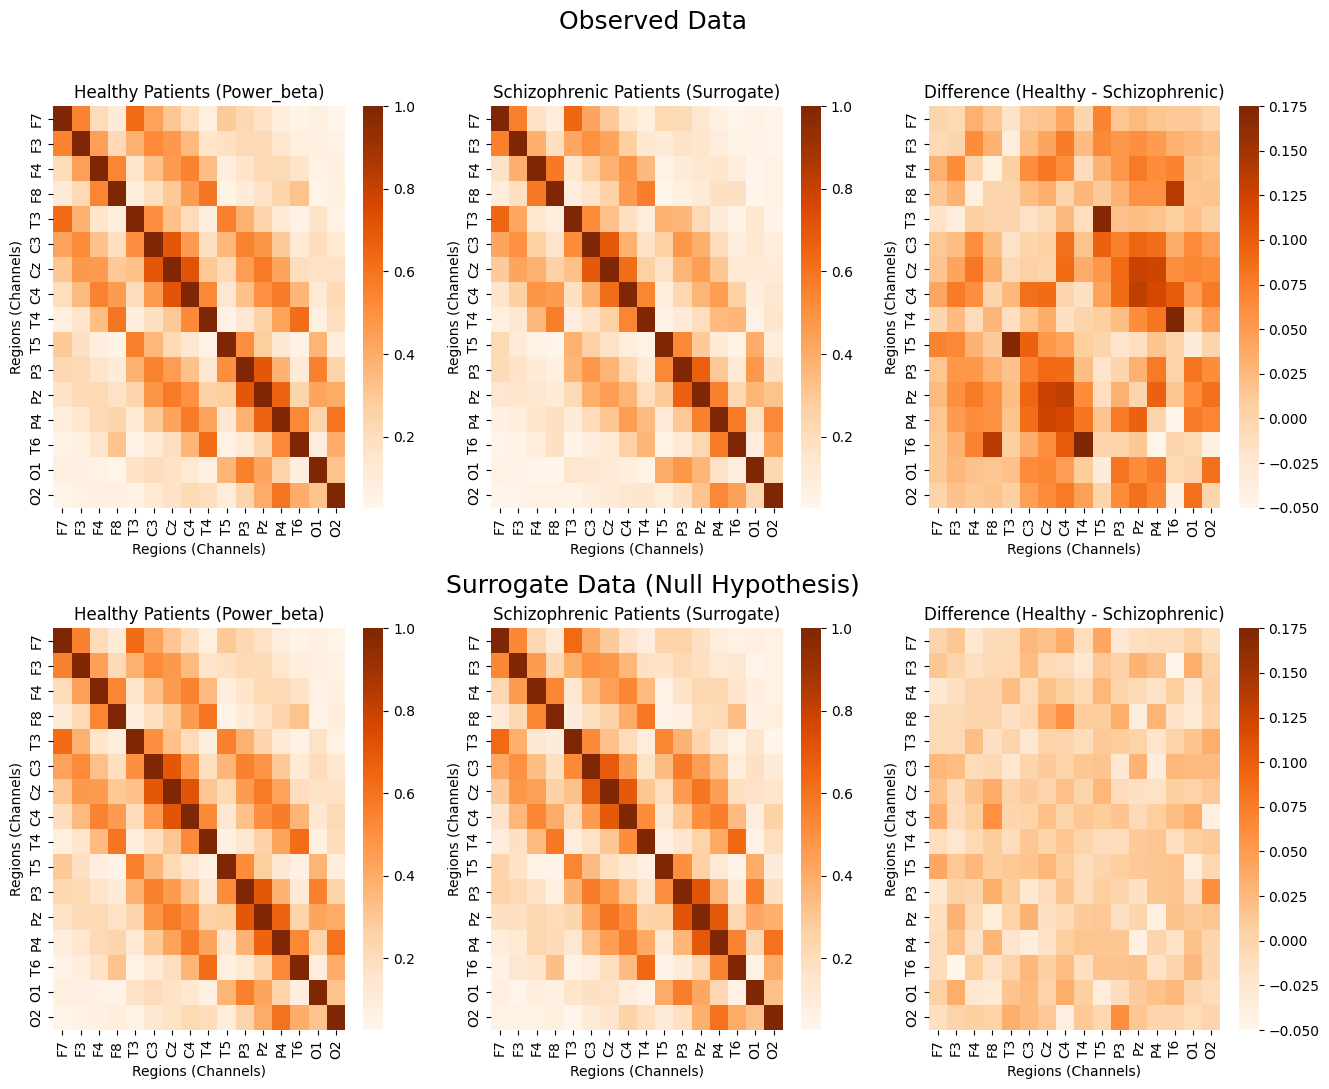

In [7]:
"""Sub-Plotting"""

fig, axes = plt.subplots(2, 3, figsize=(16, 12))

observed_diff = plot_correlation_matrices_with_surrogate(healthy_patients, df1, schizo_patients, wave_option='power_beta', surrogate_csd_dict=None, ax=axes[0])
surrogate_diff = plot_correlation_matrices_with_surrogate(healthy_patients, df1, schizo_patients, wave_option='power_beta', surrogate_csd_dict=surrogate_schizo_csd_dict, ax=axes[1])

fig.text(0.5, 0.95, "Observed Data", ha='center', va='center', fontsize=18)
fig.text(0.5, 0.48, "Surrogate Data (Null Hypothesis)", ha='center', va='center', fontsize=18)

plt.subplots_adjust(hspace=0.3, wspace=0.2)

plt.show()

In [8]:
"""Remove # To visualize observed_diff Matrix""" 
#observed_diff

'Remove # To visualize observed_diff Matrix'

In [9]:
"""Remove # To visualize surrogate_diff Matrix""" 
# surrogate_diff

'Remove # To visualize surrogate_diff Matrix'

### (2) Visualising Differences Between Surrogates & Observed

In [10]:
#Flatten Surrogate and Observed CSD matrices
flat_observed_diff = observed_diff.values.flatten()
flat_surrogate_diff = surrogate_diff.values.flatten()

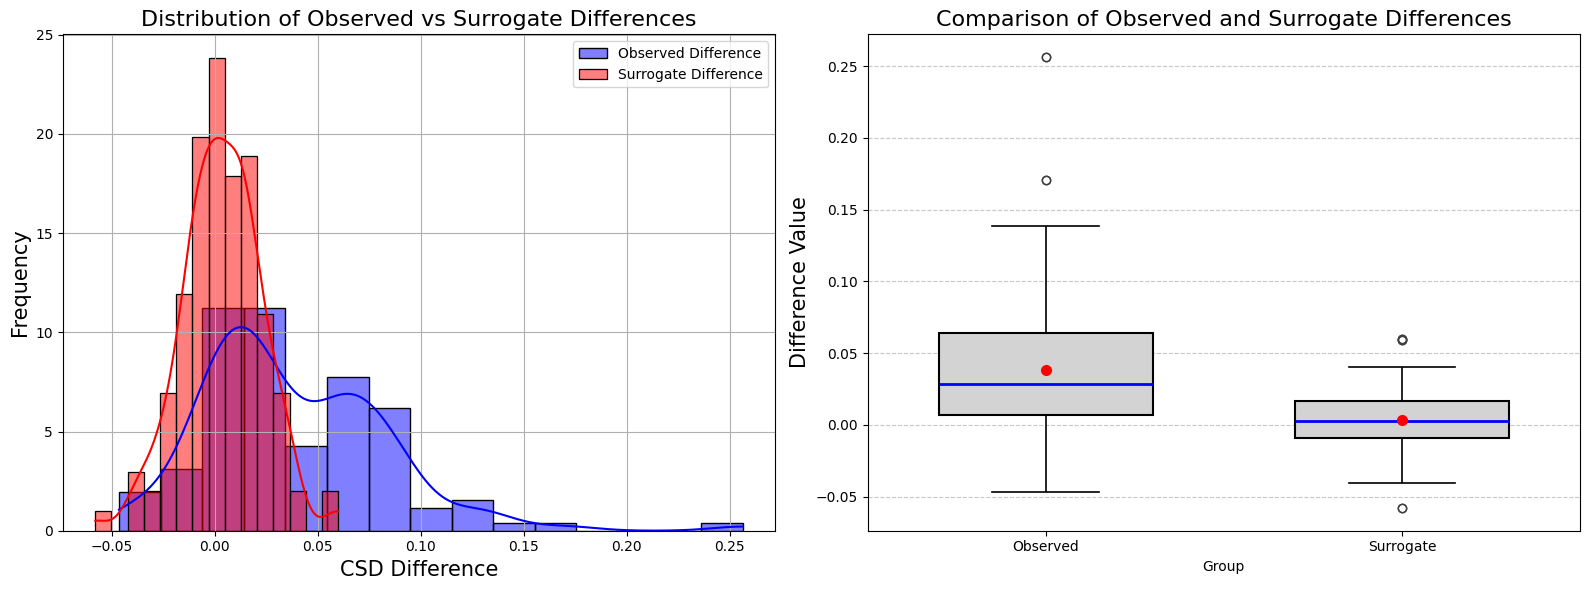

In [11]:
def plot_diff_observed_surr(flat_observed_diff, flat_surrogate_diff):
    """Visualize the distribution of Observed and Surrogate Differences"""
    
    data = pd.DataFrame({"Differences": np.concatenate([flat_observed_diff, flat_surrogate_diff]),"Group": ["Observed"] * len(flat_observed_diff) + ["Surrogate"] * len(flat_surrogate_diff)})

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    #Histogram Parameters
    sns.histplot(flat_observed_diff, kde=True, color="blue", label="Observed Difference", stat="density", bins=15, ax=axes[0])
    sns.histplot(flat_surrogate_diff, kde=True, color="red", label="Surrogate Difference", stat="density", bins=15, ax=axes[0])
    axes[0].set_title("Distribution of Observed vs Surrogate Differences", fontsize=16)
    axes[0].set_xlabel("CSD Difference", fontsize=15)
    axes[0].set_ylabel("Frequency", fontsize=15)
    axes[0].legend()
    axes[0].grid()

    #Boxplot Parameters
    sns.boxplot(x="Group", y="Differences", data=data, ax=axes[1], width=0.6, showmeans=True,
        meanprops={"marker": "o", "markerfacecolor": "red", "markeredgecolor": "red", "markersize": 7, "linestyle": "--", "color": "red", "linewidth": 1.5},
        medianprops={"color": "blue", "linewidth": 2},
        boxprops={"facecolor": "lightgray", "edgecolor": "black", "linewidth": 1.5},
        whiskerprops={"color": "black", "linewidth": 1.2},
        capprops={"color": "black", "linewidth": 1.2})

    axes[1].set_title("Comparison of Observed and Surrogate Differences", fontsize=16)
    axes[1].set_ylabel("Difference Value", fontsize=15)
    axes[1].grid(axis="y", linestyle="--", alpha=0.7)

    plt.tight_layout()
    plt.show()

plot_diff_observed_surr(flat_observed_diff, flat_surrogate_diff)

### (3) Normality Tests

In [12]:
"""Shapiro Wilk Normality Test"""

from scipy.stats import shapiro

def shapiro_wilk(flat_observed_diff, flat_surrogate_diff):
    
    #Parameters
    observed_statistic, observed_pvalue = shapiro(flat_observed_diff)
    surrogate_statistic, surrogate_pvalue = shapiro(flat_surrogate_diff)

    print("Observed p-value:", observed_pvalue)
    print("Surrogate p-value:", surrogate_pvalue)

shapiro_wilk(flat_observed_diff, flat_surrogate_diff)

Observed p-value: 6.284866207797946e-10
Surrogate p-value: 0.11316472922718929


In [13]:
"""D'Agostino-Pearson"""

from scipy.stats import normaltest

def dagostino_pearson(flat_observed_diff, flat_surrogate_diff):
    
    #Observed
    stat_obs, p_value_obs = normaltest(flat_observed_diff)
    print("Observed D'Agostino and Pearson Test:")
    print("Statistic:", stat_obs)
    print("P-value:", p_value_obs)

    #Surrogate
    stat_surr, p_value_surr = normaltest(flat_surrogate_diff)
    print("Surrogate D'Agostino and Pearson Test:")
    print("Statistic:", stat_surr)
    print("P-value:", p_value_surr)

dagostino_pearson(flat_observed_diff, flat_surrogate_diff)

Observed D'Agostino and Pearson Test:
Statistic: 68.45199517913414
P-value: 1.367219076024396e-15
Surrogate D'Agostino and Pearson Test:
Statistic: 3.0240028366829916
P-value: 0.2204682868294745


### (4) Calculating Mean Differences Through Bootstrapping

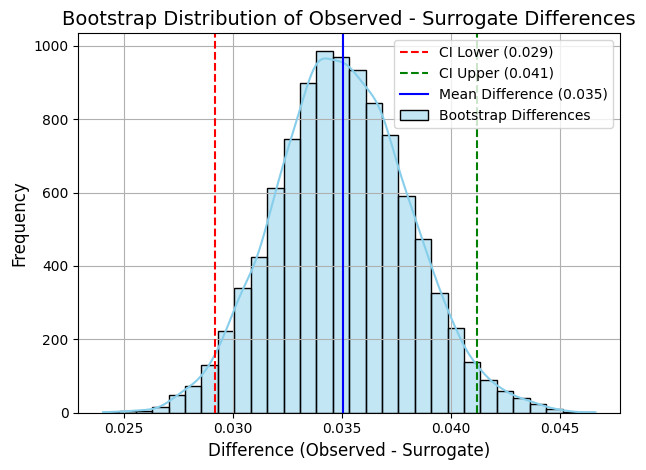

95% Confidence Interval: [0.029, 0.041]
Mean of Bootstrap Differences: 0.035
P-value: N/A


In [14]:
from sklearn.utils import resample

def bootstrapping(flat_observed_diff, flat_surrogate_diff):

    #Flattening observed and surrogate differences to 1D lists
    flat_observed_diff = observed_diff.values.flatten()
    flat_surrogate_diff = surrogate_diff.values.flatten()

    #Bootstraps
    n_bootstraps = 10000
    boot_diffs = []

    #Bootstrap Procedure
    for _ in range(n_bootstraps):
        boot_obs = resample(flat_observed_diff)
        boot_sur = resample(flat_surrogate_diff)

        boot_diffs.append(np.mean(boot_obs) - np.mean(boot_sur))

    boot_diffs = np.array(boot_diffs)
    ci_lower, ci_upper = np.percentile(boot_diffs, [2.5, 97.5])

    #The delta_critical is currently set at a default value of 0. Delta should be provided to us by domain experts
    delta_critical = 0
    p_value = np.mean(boot_diffs <= delta_critical)

    sns.histplot(boot_diffs, bins=30, kde=True, color="skyblue", label="Bootstrap Differences")

    #CI Vertical Lines
    plt.axvline(ci_lower, color='red', linestyle='--', label=f'CI Lower ({ci_lower:.3f})')
    plt.axvline(ci_upper, color='green', linestyle='--', label=f'CI Upper ({ci_upper:.3f})')

    #Mean Verical Lines
    mean_diff = np.mean(boot_diffs)
    plt.axvline(mean_diff, color='blue', linestyle='-', label=f'Mean Difference ({mean_diff:.3f})')


    plt.title('Bootstrap Distribution of Observed - Surrogate Differences', fontsize=14)
    plt.xlabel('Difference (Observed - Surrogate)', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.legend()

    plt.tight_layout()
    plt.grid()
    plt.show()

    print(f"95% Confidence Interval: [{ci_lower:.3f}, {ci_upper:.3f}]")
    print(f"Mean of Bootstrap Differences: {mean_diff:.3f}")

    #print(f"P-value: {p_value:.3f}")
    print(f"P-value: {"N/A"}")

bootstrapping(flat_observed_diff, flat_surrogate_diff)

$$p\text{-value} = \frac{\text{Number of bootstrap samples where } \text{mean difference} \leq \Delta_{\text{critical}}}{\text{Total number of bootstrap samples}}$$

### $Conclusions:$

- $\Delta_{\text{critical}}$ is a value that we were not able to extract from past research. This Delta signifies how much of a difference between observed and surrogate statistics (in our case the mean difference) should account for an actual clinical differences between both groups. In the absence of this piece of information, computing the p_value is meaningless since it is dependent on $\Delta_{\text{critical}}$

- For surrogate CSD's, future improvements would be to add noise to the healthy replica or replicate a new distribution via AR or Bootstrapping. We realize that the current method of direct replication might be a downfall.
